In [1]:
import torch
print('WARNING!!!!!!')
print('torch version:', torch.__version__)

WARNING!!!!!!
torch version: 0.4.0a0+da6c3c9


**Я обучил на кусочках $32 \times 32$ исходных изображений 4-слойную нейронную сеть со свёртками разных dilation, батчнормами и ReLU с сигмоидой на выходе. Если резать без наложений, из одной картинки получается 256, в результате размер обучающей выборки стал достаточно большим, чтобы научить что-нибудь нормальное. В качестве функции потерь брал бинарную кросс-энтропию с отношением весов 20 к 1 (посмотрел баланс классов в выборках и прикинул), чтобы больше штрафовать на плохое предсказание единичного класса. 65 эпох, каждые 30 уменьшал rearning rate в 10 раз. Учился на батчах размера 100, метрику качества на валидационном множестве считал для целых картинок, предсказание которых получал склейкой предсказаний непересекающихся кусочков, на эпохах выводил среднее значение. После обучения сети в 2 этапа подбирал порог, который из предсказания делает бинарное изображение, максимизируя среднее iou.**

## Neural networks for segmentation

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
from skimage.io import imread, imshow, imshow_collection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

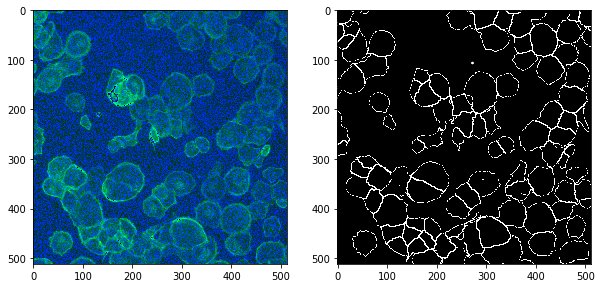

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data_utils
import torch

    
class Normalize(nn.Module):
    def forward(self, input):
        return input[:,0,:,:]

In [5]:
from os import listdir
from os.path import isfile, join
from skimage.io import imread


def read_images3D(mypath):
    names = [f for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]
    size = imread(mypath + names[0]).transpose(2,0,1).shape
    result = np.zeros((len(names),) + size)
    for i in range(len(names)):
        result[i,:,:] = imread(mypath + names[i]).transpose(2,0,1) / 255
    return result


def read_images2D(mypath):
    names = [f for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]
    size = imread(mypath + names[0]).shape
    result = np.zeros((len(names),) + size)
    for i in range(len(names)):
        result[i,:,:] = imread(mypath + names[i]) / 255
    return result

In [6]:
X_name = 'BBBC018_v1_images-fixed/'
y_name = 'BBBC018_v1_outlines/'
X_train_big = read_images3D(X_name + 'train/')
X_test_big = read_images3D(X_name + 'test/')
X_val_big = read_images3D(X_name + 'val/')
y_train_big = read_images2D(y_name + 'train/')
y_val_big = read_images2D(y_name + 'val/')

/home/andrejka/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


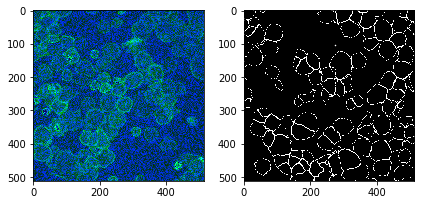

In [8]:
imshow_collection((X_val_big[0].transpose(1,2,0), y_train_big[0]))

In [10]:
def make_slices3D(image, factor=8):    
    new_height = image.shape[1] // factor
    new_width = image.shape[2] // factor
    result = np.zeros((factor ** 2, 3, new_height, new_width))
    i = 0
    for h in range(0, image.shape[1], new_height):
        for w in range(0, image.shape[2], new_width):
            result[i,:,:,:] = image[:, h:h+new_height, w:w+new_width]
            i+=1
    return result


def make_slices2D(image, factor=8):
    new_height = image.shape[0] // factor
    new_width = image.shape[1] // factor
    result = np.zeros((factor ** 2, new_height, new_width))
    i = 0
    for h in range(0, image.shape[0], new_height):
        for w in range(0, image.shape[1], new_width):
            result[i,:,:] = image[h:h+new_height, w:w+new_width]
            i+=1
    return result

In [11]:
def puzzle3D(pieces, factor=8):
    old_height = pieces.shape[2] * factor
    old_width = pieces.shape[3] * factor
    result = np.zeros((pieces.shape[1], old_height, old_width))
    i = 0
    for h in range(0, old_height, pieces.shape[2]):
        for w in range(0, old_width, pieces.shape[3]):
            result[:, h:h + pieces.shape[2], w:w + pieces.shape[3]] = pieces[i]
            i += 1
    return result


def puzzle2D(pieces, factor=8):
    old_height = pieces.shape[1] * factor
    old_width = pieces.shape[2] * factor
    result = np.zeros((old_height, old_width))
    i = 0
    for h in range(0, old_height, pieces.shape[1]):
        for w in range(0, old_width, pieces.shape[1]):
            result[h:h + pieces.shape[1], w:w + pieces.shape[2]] = pieces[i]
            i += 1
    return result

In [12]:
def makeX(images, factor=8):
    fact_sqr = factor ** 2
    size = images.shape[0] * fact_sqr
    result = np.zeros((size, images.shape[1], 
                       images.shape[2] // factor, 
                       images.shape[3] // factor))
    for i in range(0, size, fact_sqr):
        result[i:i+fact_sqr,:,:,:] = make_slices3D(images[i // fact_sqr], factor)
    return result


def makeY(images, factor=8):
    fact_sqr = factor ** 2
    size = images.shape[0] * fact_sqr
    result = np.zeros((size, 
                       images.shape[1] // factor, 
                       images.shape[2] // factor))
    for i in range(0, size, fact_sqr):
        result[i:i+fact_sqr,:,:] = make_slices2D(images[i // fact_sqr], factor)
    return result

/home/andrejka/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


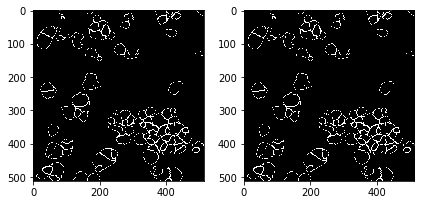

In [106]:
imshow_collection((y_train_big[2], puzzle2D(make_slices2D(y_train_big[2]))))

In [13]:
factor = 16
X_train = makeX(X_train_big, factor)
y_train = makeY(y_train_big, factor)
y_val = makeY(y_val_big, factor)

In [14]:
X_train.shape

(10496, 3, 32, 32)

/home/andrejka/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


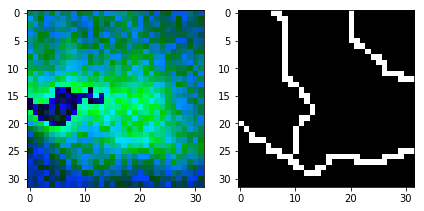

In [15]:
kek = np.random.randint(0, 10000, 1)[0]
imshow_collection((X_train[kek].transpose(1,2,0), y_train[kek]))

In [16]:
zers_perc_train = np.mean([(y_train[i] == 0).sum() / 1024 for i in range(y_train.shape[0])])
zers_perc_val = np.mean([(y_val[i] == 0).sum() / 1024 for i in range(y_val.shape[0])])
zers_perc_all = (np.sum([(y_train[i] == 0).sum() / 1024 for i in range(y_train.shape[0])]) + \
                 np.sum([(y_val[i] == 0).sum() / 1024 for i in range(y_val.shape[0])])) / \
(y_train.shape[0] + y_val.shape[0])

In [18]:
print(zers_perc_train / (1 - zers_perc_train))
print(zers_perc_val / (1 - zers_perc_val))
print(zers_perc_all / (1 - zers_perc_all))

24.65315893739409
17.918583432135666
23.387142538738072


In [19]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

In [32]:
model = nn.Sequential(
    nn.Conv2d(3, 40, dilation=1, padding=1, kernel_size=(3,3)),
    nn.BatchNorm2d(40),
    nn.ReLU(),
    nn.Conv2d(40, 30, dilation=2, padding=2, kernel_size=(3,3)),
    nn.BatchNorm2d(30),
    nn.ReLU(),
    nn.Conv2d(30, 15, dilation=1, padding=1, kernel_size=(3,3)),
    nn.BatchNorm2d(15),
    nn.ReLU(),
    nn.Conv2d(15, 1, dilation=2, padding=2, kernel_size=(3,3)),
    nn.BatchNorm2d(1),
    nn.Sigmoid(),
    Normalize()
)

In [33]:
model(torch.Tensor(X_train[:2])).size()

torch.Size([2, 32, 32])

In [34]:
def cross_entropy(y_true, y_pred, one_weight):
    return -(one_weight *  y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)).mean()

In [35]:
opt = optim.Adam(model.parameters())

train_loss = []
from torch.optim.lr_scheduler import StepLR
sch = StepLR(opt, step_size=30, gamma = 0.1)

In [36]:
param_sum = 0
for param in model.parameters():
    kek = param.size()
    j = 1
    for item in kek:
        j *= item
    param_sum += j
param_sum

16323

In [37]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [38]:
import time
num_epochs = 65
batch_size = 100
one_weight = 20

try:
    for epoch in range(num_epochs):
        start_time = time.time()
        sch.step()
        model.train(True)
        for (X_batch, y_batch) in train_loader:
            loss = cross_entropy(y_batch, model(X_batch), one_weight)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss.append(loss.data.numpy())
        model.train(False)
        ious = []
        for i in range(X_val_big.shape[0]):
            vallll = torch.Tensor(make_slices3D(X_val_big[i], factor))
            predddd = puzzle2D(model(vallll).data.numpy(), factor)
            ious.append(calc_iou(predddd > 0.855, y_val_big[i]))
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation iou with 0.855 threshold (in-iteration): \t{:.6f}".format(
            np.mean(ious)))
    
except KeyboardInterrupt:
    pass

Epoch 1 of 65 took 501.065s
  training loss (in-iteration): 	0.930837
  validation iou with 0.855 threshold (in-iteration): 	0.176452
Epoch 2 of 65 took 487.513s
  training loss (in-iteration): 	0.825229
  validation iou with 0.855 threshold (in-iteration): 	0.236415
Epoch 3 of 65 took 485.740s
  training loss (in-iteration): 	0.772477
  validation iou with 0.855 threshold (in-iteration): 	0.252246
Epoch 4 of 65 took 490.163s
  training loss (in-iteration): 	0.735360
  validation iou with 0.855 threshold (in-iteration): 	0.266153
Epoch 5 of 65 took 494.080s
  training loss (in-iteration): 	0.706382
  validation iou with 0.855 threshold (in-iteration): 	0.258875
Epoch 6 of 65 took 491.342s
  training loss (in-iteration): 	0.681663
  validation iou with 0.855 threshold (in-iteration): 	0.269689
Epoch 7 of 65 took 525.351s
  training loss (in-iteration): 	0.660437
  validation iou with 0.855 threshold (in-iteration): 	0.270267
Epoch 8 of 65 took 492.339s
  training loss (in-iteration): 	0

Epoch 62 of 65 took 484.606s
  training loss (in-iteration): 	0.489254
  validation iou with 0.855 threshold (in-iteration): 	0.302912
Epoch 63 of 65 took 499.308s
  training loss (in-iteration): 	0.486995
  validation iou with 0.855 threshold (in-iteration): 	0.303499
Epoch 64 of 65 took 502.604s
  training loss (in-iteration): 	0.487228
  validation iou with 0.855 threshold (in-iteration): 	0.303313
Epoch 65 of 65 took 511.271s
  training loss (in-iteration): 	0.488138
  validation iou with 0.855 threshold (in-iteration): 	0.303672


In [45]:
lims = np.linspace(0.83, 0.87, 40)
means = []
for lim in lims:
    ious = []
    for i in range(X_val_big.shape[0]):
        vallll = torch.Tensor(make_slices3D(X_val_big[i], factor))
        predddd = puzzle2D(model(vallll).data.numpy(), factor)
        ious.append(calc_iou(predddd > lim, y_val_big[i]))
    means.append(np.mean(ious))

In [46]:
top_limit = lims[np.argmax(means)]
new_lims = np.linspace(top_limit - 0.001, top_limit + 0.001, 10)
new_means = []
for lim in new_lims:
    ious = []
    for i in range(X_val_big.shape[0]):
        val = torch.Tensor(make_slices3D(X_val_big[i], factor))
        pred = puzzle2D(model(val).data.numpy(), factor)
        ious.append(calc_iou(pred > lim, y_val_big[i]))
    new_means.append(np.mean(ious))
    print(np.mean(ious), lim)

0.3036593380183569 0.8566923076923076
0.3037129617537974 0.8569145299145299
0.30380690311609865 0.8571367521367521
0.3038466383243486 0.8573589743589743
0.3038859107126576 0.8575811965811966
0.30389356370260756 0.8578034188034187
0.3038560377058805 0.8580256410256409
0.30373467976260876 0.8582478632478632
0.3036144036228947 0.8584700854700854
0.3034950611106998 0.8586923076923076


In [103]:
from skimage.io import imsave

def upchannel(image):
    result = np.zeros((image.shape[0], image.shape[1], 3)).astype(bool)
    for i in range(3):
        result[:,:,i] = image
    return result

preds = []
names = [f for f in sorted(listdir(X_name + 'test/')) if isfile(join(X_name + 'test/', f))]
dominate_limit = new_lims[np.argmax(new_means)]
for i in range(X_test_big.shape[0]):
    test = torch.Tensor(make_slices3D(X_test_big[i], factor))
    pred = (puzzle2D(model(test).data.numpy(), factor) > dominate_limit)
    preds.append(pred)
    plt.imsave(names[i][:-4] + '.png', pred * 255, format='png', cmap='gray') 
    plt.imsave(str(i+1) + names[i][6:-4] + '.png', 
               (upchannel(pred) + X_test_big[i].transpose(1,2,0)) / 2,
               format='png', cmap='gray')